<a href="https://colab.research.google.com/github/comptech-winter-school/image-finder/blob/ruclip/colabs/comptech_ruclip_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Allowed Resources
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Thu Jan 27 13:54:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [2]:
!pip install ruclip==0.0.1 > /dev/null

In [19]:
import os
import glob
import pandas as pd
import torch
import ruclip
import random
import numpy as np
import skimage
from glob import glob
from tqdm.auto import tqdm
from torchvision.datasets import CIFAR10, CIFAR100
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random

In [4]:
f"All models: {list(ruclip.MODELS.keys())}"

"All models: ['ruclip-vit-base-patch32-224', 'ruclip-vit-base-patch16-224', 'ruclip-vit-large-patch14-224', 'ruclip-vit-large-patch14-336', 'ruclip-vit-base-patch32-384', 'ruclip-vit-base-patch16-384']"

In [5]:
device = 'cuda'
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

# Unsplash dataset
https://unsplash.com/data

In [10]:
!mkdir datasets
!wget -O datasets/unsplash_lite.zip https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
!unzip datasets/unsplash_lite.zip -d datasets/unsplash_lite

mkdir: cannot create directory ‘datasets’: File exists
--2022-01-27 14:01:46--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 52.217.71.196
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|52.217.71.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632351052 (603M) [application/zip]
Saving to: ‘datasets/unsplash_lite.zip’

datasets/unsplash_l 100%[===================>] 603.06M  63.9MB/s    in 9.8s    

2022-01-27 14:01:56 (61.8 MB/s) - ‘datasets/unsplash_lite.zip’ saved [632351052/632351052]

Archive:  datasets/unsplash_lite.zip
  inflating: datasets/unsplash_lite/collections.tsv000  
  inflating: datasets/unsplash_lite/__MACOSX/._collections.tsv000  
  inflating: datasets/unsplash_lite/colors.tsv000  
  inflating: datasets/unsplash_lite/__MACOSX/._colors.tsv000  
  inflating: datasets/un

In [27]:
!ls datasets/unsplash_lite/

collections.tsv000  DOCS.md	     photos.tsv000
colors.tsv000	    keywords.tsv000  README.md
conversions.tsv000  __MACOSX	     TERMS.md


In [35]:
path = 'datasets/unsplash_lite'
documents = ['photos', 'keywords', 'collections', 'conversions', 'colors']
datasets = {}

for doc in documents:
    file = os.path.join(path, doc + ".tsv000")
    print(file)

    df = pd.read_csv(file, sep='\t', header=0)
    datasets[doc] = df

datasets/unsplash_lite/photos.tsv000
datasets/unsplash_lite/keywords.tsv000
datasets/unsplash_lite/collections.tsv000
datasets/unsplash_lite/conversions.tsv000
datasets/unsplash_lite/colors.tsv000


In [36]:
datasets['photos'].head()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,photographer_first_name,photographer_last_name,exif_camera_make,exif_camera_model,exif_iso,exif_aperture_value,exif_focal_length,exif_exposure_time,photo_location_name,photo_location_latitude,photo_location_longitude,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,XMyPniM9LF0,https://unsplash.com/photos/XMyPniM9LF0,https://images.unsplash.com/uploads/1411949294...,2014-09-29 00:08:38.594364,t,4272,2848,1.50,Woman exploring a forest,michellespencer77,Michelle,Spencer,Canon,Canon EOS REBEL T3,400.0,1.8,50.0,1/100,NaN,NaN,NaN,NaN,NaN,2375421,6967,woman walking in the middle of forest,NaN,NaN,NaN,NaN,L56bVcRRIWMh.gVunlS4SMbsRRxr
1,rDLBArZUl1c,https://unsplash.com/photos/rDLBArZUl1c,https://images.unsplash.com/photo-141633941111...,2014-11-18 19:36:57.08945,t,3000,4000,0.75,Succulents in a terrarium,ugmonk,Jeff,Sheldon,Panasonic,DMC-GF1,100.0,1.8,20.0,1/200,NaN,NaN,NaN,NaN,NaN,13784815,82141,succulent plants in clear glass terrarium,NaN,NaN,NaN,NaN,LvI$4txu%2s:_4t6WUj]xat7RPoe
2,cNDGZ2sQ3Bo,https://unsplash.com/photos/cNDGZ2sQ3Bo,https://images.unsplash.com/photo-142014251503...,2015-01-01 20:02:02.097036,t,2564,1710,1.50,Rural winter mountainside,johnprice,John,Price,Canon,Canon EOS 60D,100.0,9.0,40.0,1/320,NaN,NaN,NaN,NaN,NaN,1302461,3428,rocky mountain under gray sky at daytime,NaN,NaN,NaN,NaN,LhMj%NxvM{t7_4t7aeoM%2M{ozj[
3,iuZ_D1eoq9k,https://unsplash.com/photos/iuZ_D1eoq9k,https://images.unsplash.com/photo-141487280988...,2014-11-01 20:15:13.410073,t,2912,4368,0.67,Poppy seeds and flowers,krisatomic,Kris,Atomic,Canon,Canon EOS 5D,100.0,1.6,50.0,1/1600,NaN,NaN,NaN,NaN,NaN,2890238,33704,red common poppy flower selective focus phography,NaN,NaN,NaN,NaN,LSC7DirZAsX7}Br@GEWWmnoLWCnj
4,BeD3vjQ8SI0,https://unsplash.com/photos/BeD3vjQ8SI0,https://images.unsplash.com/photo-141700759404...,2014-11-26 13:13:50.134383,t,4896,3264,1.50,Silhouette near dark trees,jonaseriksson,Jonas,Eriksson,FUJIFILM,X-E1,200.0,1.4,35.0,1/1700,NaN,NaN,NaN,NaN,NaN,8704860,49662,trees during night time,NaN,NaN,NaN,NaN,L25|_:V@0hxtI=W;odae0ht6=^NG


In [38]:
datasets['photos'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   photo_id                        25000 non-null  object 
 1   photo_url                       25000 non-null  object 
 2   photo_image_url                 25000 non-null  object 
 3   photo_submitted_at              25000 non-null  object 
 4   photo_featured                  25000 non-null  object 
 5   photo_width                     25000 non-null  int64  
 6   photo_height                    25000 non-null  int64  
 7   photo_aspect_ratio              25000 non-null  float64
 8   photo_description               10902 non-null  object 
 9   photographer_username           25000 non-null  object 
 10  photographer_first_name         25000 non-null  object 
 11  photographer_last_name          23418 non-null  object 
 12  exif_camera_make                

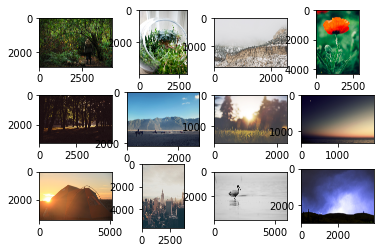

In [56]:
fig, ax = plt.subplots(3,4)
for i, photo in enumerate(datasets['photos']['photo_image_url'].iloc[:12]):
    response = requests.get(photo)
    img = Image.open(BytesIO(response.content))
    ax.reshape(-1)[i].imshow(img, )

### Prediction [Minimal Example]

8it [00:00, 48.00it/s]


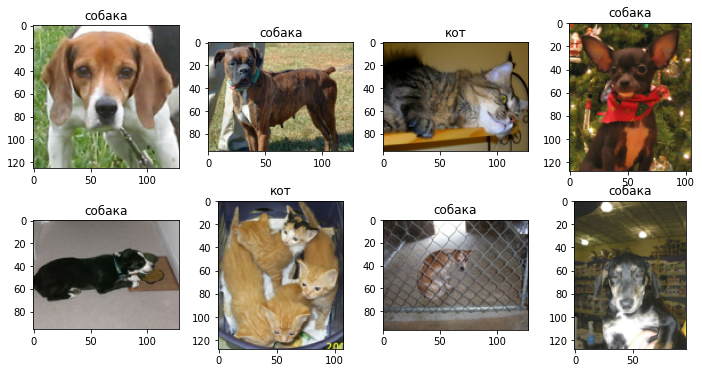

In [ ]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random

classes = ['кот', 'собака']
templates = ['{}', 'это {}', 'на картинке {}', 'это {}, домашнее животное']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

bs4_urls = requests.get('https://raw.githubusercontent.com/sberbank-ai/ru-dolph/master/pics/pipelines/cats_vs_dogs_bs4.json').json()
pil_images = [Image.open(BytesIO(base64.b64decode(bs4_url))) for bs4_url in bs4_urls]

with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    pred_labels = predictor.run(pil_images, text_latents)

f, ax = plt.subplots(2,4, figsize=(12,6))
for i, (pil_img, pred_label) in enumerate(zip(pil_images, pred_labels)):
    ax[i//4, i%4].imshow(pil_img)
    ax[i//4, i%4].set_title(classes[pred_label])

# Calculating cosine similarity

8it [00:00, 72.26it/s]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

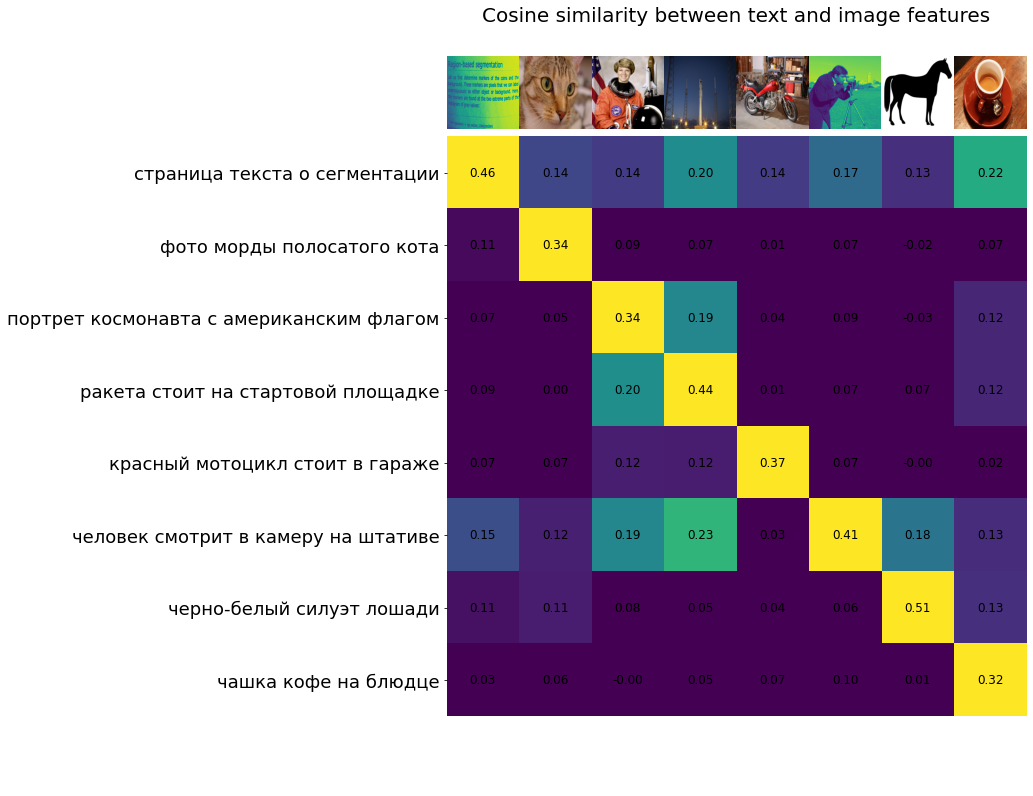

In [ ]:
descriptions = {
    'page.png': 'страница текста о сегментации',
    'chelsea.png': 'фото морды полосатого кота',
    'astronaut.png': 'портрет космонавта с американским флагом',
    'rocket.jpg': 'ракета стоит на стартовой площадке',
    'motorcycle_right.png': 'красный мотоцикл стоит в гараже',
    'camera.png': 'человек смотрит в камеру на штативе',
    'horse.png': 'черно-белый силуэт лошади',
    'coffee.png': 'чашка кофе на блюдце'
}

templates = ['{}', 'это {}']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

classes = list(descriptions.values())
pil_images = [Image.open(f'{skimage.data_dir}/{image_name}') for image_name in descriptions]

with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    image_latents = predictor.get_image_latents(pil_images)
    logits_per_text = torch.matmul(text_latents, image_latents.t())
    logits_per_image = logits_per_text.t()

count = len(classes)
similarity = logits_per_image.cpu().numpy()

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), classes, fontsize=18)
plt.xticks([])

for i, pil_img in enumerate(pil_images):
    plt.imshow(pil_img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

for side in ['left', 'top', 'right', 'bottom']:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
plt.title('Cosine similarity between text and image features', size=20)

# Image distance for arbitary input

In [ ]:
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

8it [00:00, 37.64it/s]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

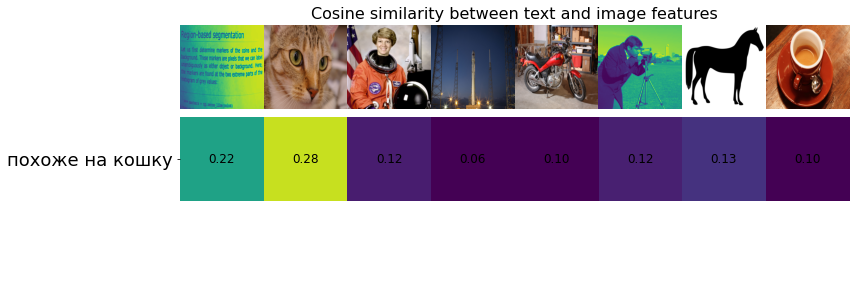

In [ ]:
input_text = 'похоже на кошку'

descriptions = {
    'page.png': 'страница текста о сегментации',
    'chelsea.png': 'фото морды полосатого кота',
    'astronaut.png': 'портрет космонавта с американским флагом',
    'rocket.jpg': 'ракета стоит на стартовой площадке',
    'motorcycle_right.png': 'красный мотоцикл стоит в гараже',
    'camera.png': 'человек смотрит в камеру на штативе',
    'horse.png': 'черно-белый силуэт лошади',
    'coffee.png': 'чашка кофе на блюдце'
}

templates = ['{}', 'это {}']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

classes = [input_text]
pil_images = [Image.open(f'{skimage.data_dir}/{image_name}') for image_name in descriptions]

with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    image_latents = predictor.get_image_latents(pil_images)
    logits_per_text = torch.matmul(text_latents, image_latents.t())
    logits_per_image = logits_per_text.t()

# text_latents.shape, image_latents.shape, logits_per_text.shape, logits_per_image.shape

count = len(classes)

similarity = logits_per_image.cpu().numpy()

plt.figure(figsize=(12, 8))
plt.imshow(similarity.T, vmin=0.1, vmax=0.3)
plt.yticks(range(count), classes, fontsize=18)
plt.xticks([])



for i, pil_img in enumerate(pil_images):
    plt.imshow(pil_img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(y, x, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

for side in ['left', 'top', 'right', 'bottom']:
    plt.gca().spines[side].set_visible(False)

plt.xlim(left=-0.5, right=7.5)
plt.ylim(bottom=1.6, top=-1.6)
plt.title('Cosine similarity between text and image features', size=16)

In [ ]:
def cos_similarity(predictor, text, images, plot=True):
    """
    Predictor converts text and images to latent and optionally plot it
    predictor – ruclip.Predictor
    text – single string input
    images – list of PIL images
    plot – if True plots cosine similarity of text vs images
    """
    classes = [text, ]

    with torch.no_grad():
        text_latents = predictor.get_text_latents(classes)
        image_latents = predictor.get_image_latents(images)
        logits_per_image = torch.matmul(text_latents, image_latents.t()).t()

    similarity = logits_per_image.cpu().numpy()

    if plot:
        count = len(classes)
        plt.figure(figsize=(12, 8))
        plt.imshow(similarity.T, vmin=0.1, vmax=0.3)
        plt.yticks(range(count), classes, fontsize=18)
        plt.xticks([])

        for i, pil_img in enumerate(images):
            plt.imshow(pil_img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

        for x in range(similarity.shape[1]):
            for y in range(similarity.shape[0]):
                plt.text(y, x, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

        for side in ['left', 'top', 'right', 'bottom']:
            plt.gca().spines[side].set_visible(False)

        plt.xlim(left=-0.5, right=7.5)
        plt.ylim(bottom=1.6, top=-1.6)
        plt.title('Cosine similarity between text and image features', size=16)

In [ ]:
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
templates = ['{}', 'это {}']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

descriptions = {
    'page.png': 'страница текста о сегментации',
    'chelsea.png': 'фото морды полосатого кота',
    'astronaut.png': 'портрет космонавта с американским флагом',
    'rocket.jpg': 'ракета стоит на стартовой площадке',
    'motorcycle_right.png': 'красный мотоцикл стоит в гараже',
    'camera.png': 'человек смотрит в камеру на штативе',
    'horse.png': 'черно-белый силуэт лошади',
    'coffee.png': 'чашка кофе на блюдце'
}

pil_images = [Image.open(f'{skimage.data_dir}/{image_name}') for image_name in descriptions]

In [ ]:
# test some functions

8it [00:00, 73.87it/s]


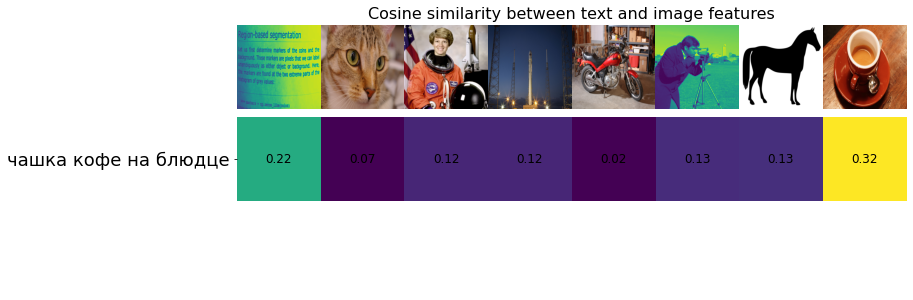

In [ ]:
text = 'чашка кофе на блюдце'
cos_similarity(predictor, text, pil_images)

In [ ]:
text = 'чашка кофе на блюдце'
cos_similarity(predictor, text, pil_images, plot=False)

8it [00:00, 126.54it/s]


8it [00:00, 138.47it/s]


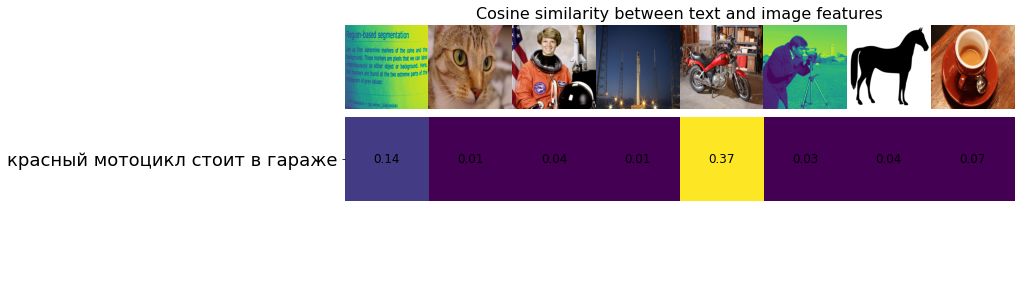

In [ ]:
text = 'красный мотоцикл стоит в гараже'
cos_similarity(predictor, text, pil_images, plot=True)